In [29]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import integrate
from scipy.integrate import ode
from scipy.integrate import quad
from scipy.integrate import trapz
%matplotlib inline

In [32]:
Vm = 105*1.414   #Phase peak voltage                 
freq = 400
w=2*np.pi *freq    
J = 0.0001675       #moment of inertia
T_l = 1          #load torque
B=0 #0.006      #coefficient of friction 
P=4          #no of poles
Rs=.047    #stator resistance
Rr=.05     #rotor resistance
Lm=8.71/w  #mutual inductance
Lls=.433/w #stator leakage inductance
Llr=.623/w
Ls=Lm + Lls   #stator inductance
Lr=Lm + Llr   # rotor inductance
tr=Lr/Rr #rotor time constant
wrref=100
kp=.005
ki=.01
kpi=.1
kii=1
Ts=.0000625
iqref=iqref1=ewr=ewr1=eid=eiq=eid1=eiq1=ids=iqs=vdref=vqref=vdref1=vqref1=we=wsl=we1=theta=theta1=vas=vbs=vcs=0

R=([Rs,0,0,0],[0,Rs,0,0],[0,0,Rr,0],[0,0,0,Rr])      
L=([Ls,0,Lm,0],[0,Ls,0,Lm],[Lm,0,Lr,0],[0,Lm,0,Lr])
G=([0,0,0,0],[0,0,0,0],[0,Lm,0,Lr],[-Lm,0,-Lr,0])
invL=np.linalg.inv(L)

vdq=np.zeros((2,1))
v=np.zeros((4,1))
i=np.zeros((4,1))
di_dt=np.zeros((4,1))

torque, i_as, i_bs, i_cs ,speed,t = ([] for i in range(6))

s0 = [0, 0, 0, 0, 0]
t0 = 0
t_end = 2
dt = 0.0001

In [33]:
def dxdt(t, x,v_as,v_bs,v_cs):
    
    i_ds, i_qs, i_dr, i_qr, w_r = x[0], x[1], x[2], x[3], x[4]
    
    c = ([1,-.5,-.5],[0,.866,-.866])
    vdq = ((2./3)*Vm)*np.dot(c ,([v_as],
                                 [v_bs],
                                 [v_cs]))
#      vdq = ((2./3)*Vm)*np.dot(c ,([np.sin(w*t)],
#                                  [np.sin(w*t -(2./3)*np.pi)],
#                                  [np.sin(w*t + (2./3)*np.pi)]))

    
    v[0], v[1] = vdq[0], vdq[1]
    i[0], i[1], i[2], i[3] = i_ds, i_qs, i_dr, i_qr
   
    di_dt = np.dot(invL ,(v-(np.dot(R,i) + w_r*np.dot(G,i))))
    dids_dt, diqs_dt, didr_dt, diqr_dt = di_dt[0], di_dt[1], di_dt[2], di_dt[3]

    Te = (3*Lm*((i[2] * i[1]) -(i[3] *i[0])))

    dwr_dt = (Te - T_l )*P/(2*J) + (-(B/J))*w_r 
    return [dids_dt, diqs_dt, didr_dt, diqr_dt, dwr_dt]

In [34]:
solver = integrate.ode(dxdt)
solver.set_integrator('dopri5')
solver.set_initial_value(s0, t0)
solver.set_f_params(vas,vbs,vcs)

while solver.successful() and solver.t < t_end:
    i_ds, i_qs ,i_dr, i_qr, w_r = solver.integrate(solver.t+dt)
    ias = i_ds
    ibs = (-.5)*i_ds+(.866)*i_qs
    ics = (-.5)*i_ds-(.866)*i_qs
    Te1 = (3*Lm*((i_dr * i_qs) -(i_qr *i_ds)))
    
    torque.append(Te1)
    i_as.append(ias)
    i_bs.append(ibs)
    i_cs.append(ics)
    t.append(solver.t)
    speed.append(w_r)
    
    ids=(2./3)*(ias *np.cos(theta) +ibs* np.cos(theta - 2 *np.pi/3) +ics*cos(theta + 2*np.pi/3))
    iqs=(-2./3)*(ias *np.sin(theta) +ibs* np.sin(theta - 2 *np.pi/3) +ics*sin(theta + 2*np.pi/3))
    
    ewr=wrref-w_r
    iqref=iqref1+kp*(ewr-ewr1)+.05*Ts*ki*(ewr+ewr1)
    ewr1=ewr
    iqref1=iqref
    
    idref=1 /Lm
    eid=idref- ids
    vdref=vdref1+kp*(eid-eid1)+.05*Ts*ki*(eid+eid1)
    eid1=eid
    vdref1=vdref
    
    eiq=iqref-iqs
    vqref=vqref1+kp*(eiq-eiq1)+.05*Ts*ki*(eiq+eiq1)
    eiq1=eiq
    vqref1=vqref
    
    wsl=(1/tr)*(iqref/idref)
    we=wsl+w_r
    theta=theta1+.05*Ts*(we+we1)
    we1=we
    
    vas=vdref * np.cos(theta) - vqref * np.sin(theta)
    vbs=vdref * np.cos(theta - 2. *np.pi /3) - vqref * np.sin(theta - 2. *np.pi /3)
    vcs=vdref * np.cos(theta + 2. *np.pi /3) - vqref * np.sin(theta + 2. *np.pi /3)

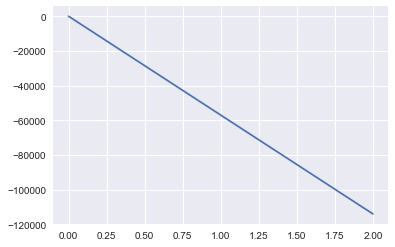

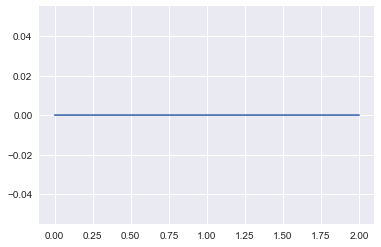

[1.6, 1.65, 30, -30]

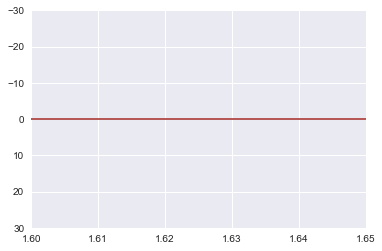

In [35]:
speed= np.dot(60/(4*np.pi) ,speed)
plt.plot(t,speed)
plt.show()
plt.plot(t,torque)
plt.show()

plt.plot(t,i_as)
plt.plot(t,i_bs)
plt.plot(t,i_cs)
plt.axis([1.6,1.65,30,-30])